In [1]:
import os
import pprint
from igor2.packed import load as loadpxp

import matplotlib.pylab as plt
import numpy as np
import statistics
from scipy import stats

import pandas as pd
import csv

In [2]:
def get_datafiles(files):
    datafiles = []
    for file in files:
        datafiles.append(loadpxp(file))
    return datafiles

In [3]:
def get_recordings(datafile):
    try:
        DATA = []
        i = 0
        while True:
            key = b'RecordA%i' % i
            if key in datafile[1]['root']:
                DATA.append(datafile[1]['root'][key].wave['wave']['wData'])
                i += 1
            else:
                break
        recordings = np.array(DATA)
        return recordings
    except Exception as e:
        print(f'Recordings were not loaded: {e}')
        return -1

In [4]:
def find_nm_files(root_folder):
    nm_paths = []
    
    # Walk through all directories and files in the root_folder
    for folder, _, files in os.walk(root_folder):
        # Check each file in the current directory
        for file in files:

            # Skip files with specific extensions
            if any(ext in file for ext in ['HDF5', 'txt', 'pdf', 'log', 'xlsx']):
                break
            # Construct the full path of the file
            file_path = os.path.join(folder, file)
            normalized_path = os.path.normpath(file_path)
            forward_slash_path = normalized_path.replace("\\", "/")
            nm_paths.append(forward_slash_path)
            #print('-', file)

    return nm_paths

In [17]:
def get_batches_rec(diffs):
    batch_size = 6
    means = []
    std = []
    for i in range(0, len(diffs), batch_size):
        means.append(np.mean(diffs[i:i+batch_size]))
        #sem.append(stats.sem(diffs[i:i+batch_size]))
        std.append(np.std(diffs[i:i+batch_size]))
    return means, std
            

In [64]:
def get_mins_maxs_baselines(diffs):
    batch_size = 6
    mins = []
    maxs = []
    for i in range(0, len(diffs), batch_size):
        mins.append(np.min(diffs[i:i+batch_size]))
        maxs.append(np.max(diffs[i:i+batch_size]))
    return mins, maxs

In [98]:
def get_std_baseline(info_df, diffs):
    std = np.std(diffs[(info_df["infusion start"][i]*6-30):info_df["infusion start"][i]*6])
    return std

In [6]:
def get_diffs2(recordings):
    diffs = []
    for recording in recordings:
        diff = find_diff2(recording)
        if diff<0.1: #otherwise the cell was momentarily lost
            diffs.append(diff)
        else:
            print("cell was lost")
    return diffs

In [7]:
def get_baselines(recordings):
    baselines = []
    for recording in recordings:
        baseline = recording[52000:58000]  #good values?
        baselines.append(baseline)
    return baselines

In [8]:
def find_diff2(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  avg_baseline - min

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

In [12]:
def find_diff(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  min - avg_baseline

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

In [15]:
def get_diffs(recordings):
    diffs = []
    for recording in recordings:
        diff = find_diff(recording)
        if diff>-0.17 :
            diffs.append(diff)
    return diffs

In [52]:
'''
def norm_batches(diffs):
    batch_size = 6
    means_norm = []
    for i in range(0, len(diffs), batch_size):
        batch = diffs[i:i+batch_size]
        means_norm.append((np.mean(batch) - np.min(batch))/ (np.max(batch) - np.min(batch)))               
    return means_norm
'''

In [53]:
'''
def norm_batches2(diffs):
    batch_size = 6
    means_norm = []
    
    baseline_m = np.mean(diffs[0:30])
    baseline_std = np.std(diffs[0:30])
    
    for i in range(0, len(diffs), batch_size):
        batch = diffs[i:i+batch_size]
        means_norm.append((np.mean(batch) - baseline_m) / baseline_std)      
    return means_norm
'''

## try with one file

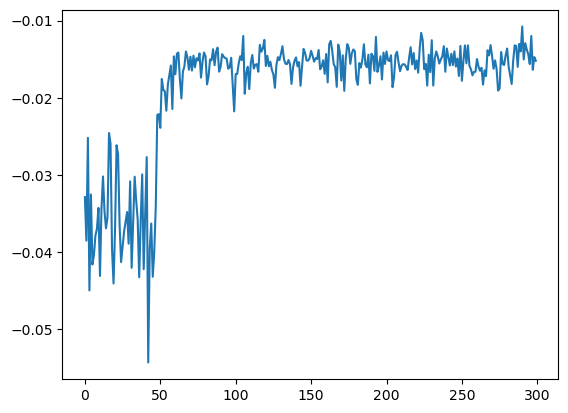

In [54]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')
recordings = get_recordings(datafile)
diffs = []
for recording in recordings:
    diffs.append(find_diff(recording))
plt.plot(diffs)

In [25]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)

len(recordings)

get_batches_rec(diffs)

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp


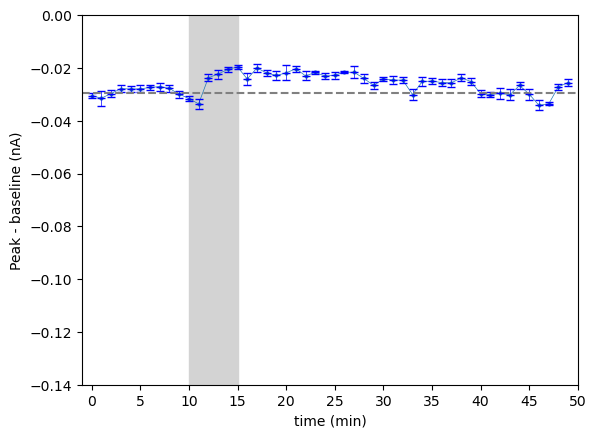

In [13]:
file = ('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp')
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)
batches_m, batches_std = get_batches_rec(diffs)

fig, ax = plt.subplots()
        
ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

ax.set_xlim(-1,50)
ax.set_ylim(-0.14, 0)
ax.set_ylabel("Peak - baseline (nA)")
ax.set_xlabel("time (min)")
ax.axvspan(10, 15, color='lightgrey')
ax.set_xticks(np.arange(0, 51, 5))
plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
plt.show()


D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
[0.024988670398124246, 0.025554444850972288]


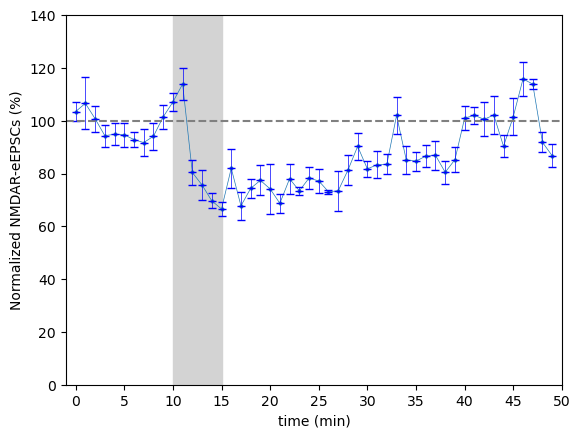

In [18]:
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
diffs = get_diffs2(recordings)
batches_m, batches_std = get_batches_rec(diffs)
print(batches_m[35:37])

# Calculate baseline mean and standard deviation
baseline_m = np.mean(batches_m[0:5])
baseline_std = np.std(batches_m[0:5])

# Normalization by baseline
batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

fig, ax = plt.subplots()
ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
ax.set_xlim(-1, 50 )
ax.set_ylim( 0, 140)
ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
ax.set_xlabel("time (min)")
ax.set_xticks(np.arange(0, 51, 5))
ax.axvspan(10, 15, color='lightgrey')
plt.axhline(100, color="grey", linestyle="--")

plt.show()

## try for all files

In [89]:
files = find_nm_files('D:\Internship_Rebola_ICM\RAW_DATA_TO_ANALYSE_WASHOUT_q')
datafiles = get_datafiles(files)

In [90]:
file_info = open('C:/Users/laura.gonzalez/Programming/Intracellular_recording/src/Files1q.csv', 'r')  
info_df = pd.read_csv(file_info, header=0, sep=';')
info_df

,Files,euthanize method,Holding (mV),infusion,infusion concentration,infusion start,infusion end,notes
0,04Jul2024c1_000,xyla euthasol,-60,APV,50µM,10,15,ok
1,03Jul2024c2_000,xyla euthasol,-60,APV,50µM,5,15,ok


## RAW DIFFERENCES ACROSS SWEEPS

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


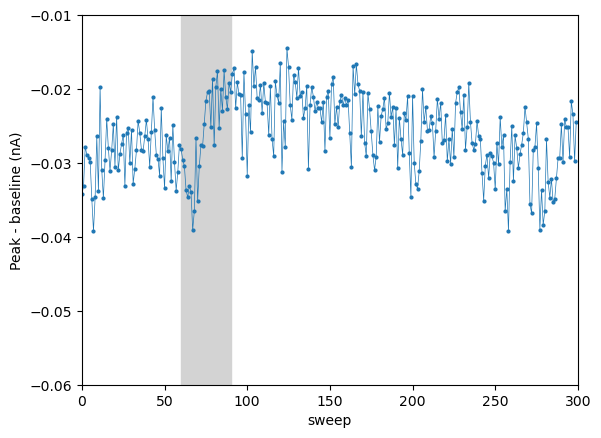

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


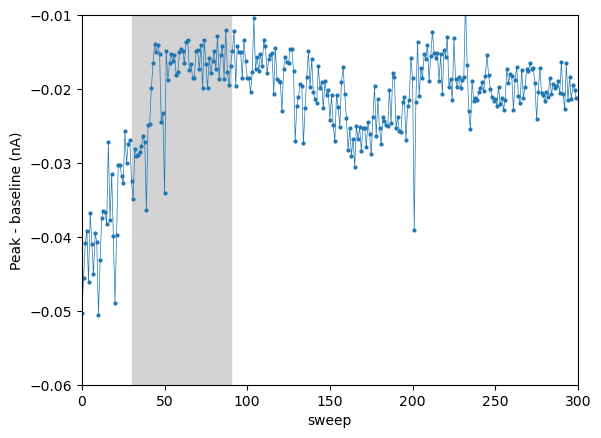

In [18]:
i=0
for datafile in datafiles:
    try:
        #print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        #datafile = loadpxp(file)
        recordings = get_recordings(datafile)

        diffs = []
        for recording in recordings:
            diff = find_diff(recording)
            if diff>-0.17 :
                diffs.append(diff)

        fig, ax = plt.subplots()
        ax.plot(diffs, marker = "o", linewidth = 0.5, markersize=2 )
        ax.set_xlim(0,300)
        ax.set_ylim(-0.06, -0.01)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("sweep")
        ax.axvspan(info_df["infusion start"][i]*6, info_df["infusion end"][i]*6, color='lightgrey')
        
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

## 50 BATCHES of 6 POINTS EACH

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


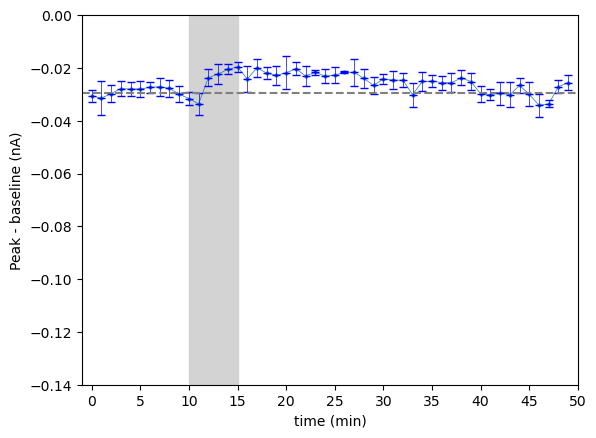

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


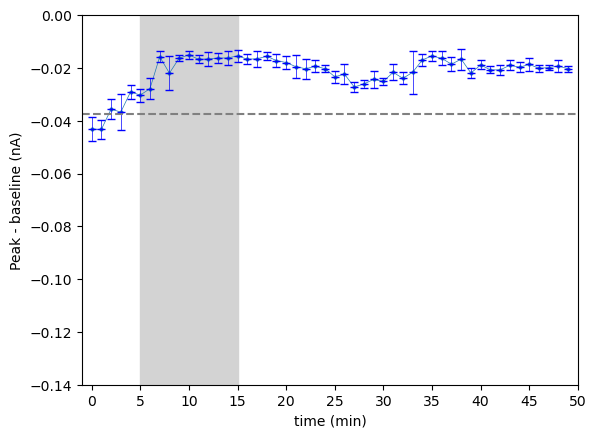

In [19]:
i=0
for datafile in datafiles:
    try:

        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        #datafile = loadpxp(file)
        recordings = get_recordings(datafile)
        diffs = get_diffs(recordings)
        batches_m, batches_std = get_batches_rec(diffs)

        fig, ax = plt.subplots()
        
        ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
        ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

        ax.set_xlim(-1,50)
        ax.set_ylim(-0.14, 0)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("time (min)")
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax.set_xticks(np.arange(0, 51, 5))
        plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

## 50 BATCHES of 6 POINTS EACH noise removed

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.
NOISE  [0.006417265048603488, 0.01950840426508002, 0.01076727078391776, 0.007295962850621118, 0.007865978500135928, 0.008499770621410621, 0.00630291833726275, 0.010622109527383627, 0.010846937578533472, 0.008952647857808763, 0.006509386505264045, 0.012505447863844735, 0.007478058679977612, 0.010061220159717985, 0.0054249719245805655, 0.005417026705135303, 0.014032432282230792, 0.010955486363571743, 0.007030549718703899, 0.010090638911981795, 0.016728974122090776, 0.0070275434376634305, 0.01131226939034416, 0.003229837628567739, 0.008138477893034804, 0.008270754993814744, 0.0014258441891105145, 0.013922380318633187, 0.008812854942933976, 0.008630437076219896, 0.005981673888066558, 0.010142819763415994, 0.007949510679042357, 0.013713657417121841, 0.011102150828757373, 0.00793072130294152, 0.007932653932169437, 0.009712382241655021

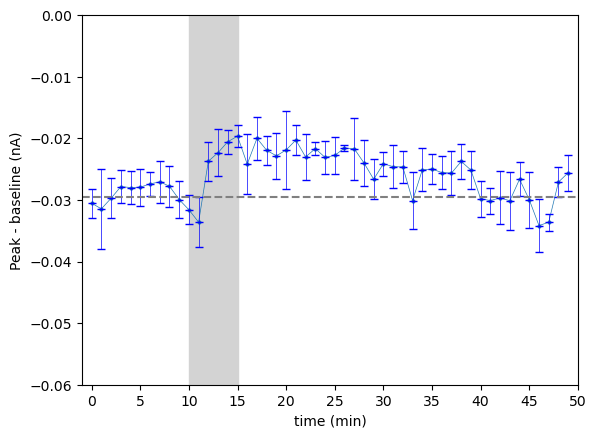

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.
NOISE  [0.013584386266400267, 0.011078959310034345, 0.011121799017184575, 0.018646347889729638, 0.006955714350458692, 0.0067035074073064985, 0.011637056929103735, 0.00597286963527824, 0.019301720650956197, 0.0031325623509170647, 0.004049053736525652, 0.0038823115694717504, 0.0064803971354370805, 0.005810100077568235, 0.007509732036036786, 0.007452827116705977, 0.005198425829993327, 0.01004414850519196, 0.004469935442769156, 0.006268882611184162, 0.007317865836441364, 0.01248934236669998, 0.012426532222014237, 0.005926057293747032, 0.00365522873038672, 0.006268345790548253, 0.011291010561654252, 0.005442902278355904, 0.003817890900014345, 0.009271422622212883, 0.0037180388809960226, 0.007377025488952367, 0.005829641019156149, 0.025400552434547363, 0.0069120158129479786, 0.0066635664913337125, 0.007737566463746466, 0.00838338371877

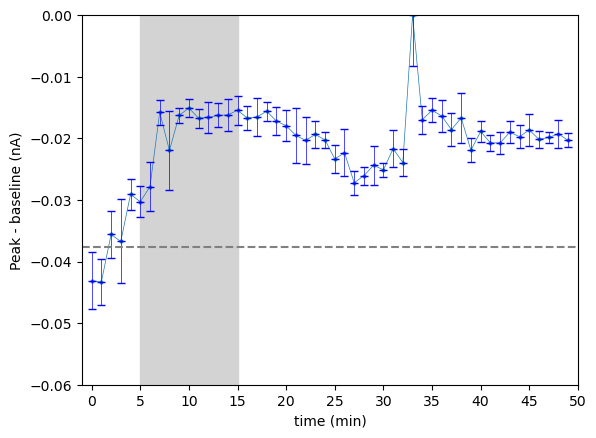

In [77]:
i=0
for datafile in datafiles:
    try:

        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        recordings = get_recordings(datafile)
        diffs = get_diffs(recordings)
        batches_m, batches_std = get_batches_rec(diffs)

        #remove noise
        bsl_mins, bsl_maxs = get_mins_maxs_baselines(diffs)
        noises = []
        for k in range(len(bsl_mins)):
            noises.append(np.abs(bsl_mins[k] - bsl_maxs[k]))

        print("NOISE ", noises )
        print(len(noises))
        
        for j in range(len(batches_m)):
            if np.abs(batches_m[j]) <= noises[j]: ##0.02
                print(batches_m[j], "below threshold :", noises[j])
                batches_m[j] = 0.00
        

        fig, ax = plt.subplots()
        
        ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
        ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

        ax.set_xlim(-1,50)
        ax.set_ylim(-0.06, 0)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("time (min)")
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax.set_xticks(np.arange(0, 51, 5))
        plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

## NORMALIZATION BY BASELINE

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.
[0.030533017566424583, 0.03144879321289438, 0.029733574927693924, 0.027842881841135054, 0.02798489360222937, 0.027931299205948334, 0.02740272758771301, 0.027066934843295764, 0.027767473847699883, 0.029935283017992618]
[0.03159304156426516, 0.03360935482737553, 0.023722696733786557, 0.022321493479897706, 0.020553235569689493]
[0.019645673570163277, 0.024190551789819336, 0.019997159888026132, 0.021949052482189185, 0.022843622951617987, 0.021886206535003172, 0.02027737191540389, 0.02302507458698085, 0.021673188872294646, 0.02309402254601199, 0.022775229728359093, 0.021571064273499318, 0.021678986785812298, 0.023988485682121207, 0.026641096233443656, 0.024119331246153702, 0.024598513666520067, 0.024645218708687685, 0.030097462100826516, 0.02511901494292866, 0.024988670398124246, 0.025554444850972288, 0.025645027470331243, 0.02374905

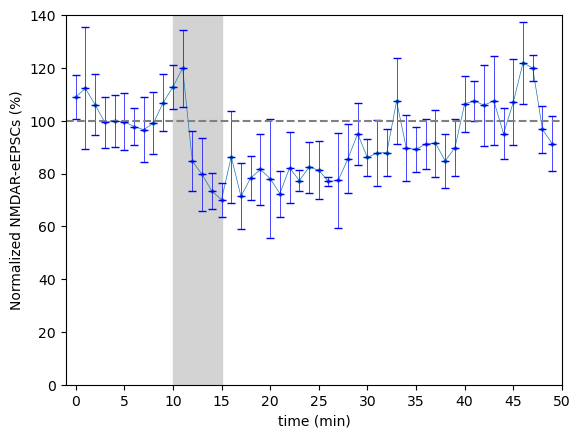

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.
[0.0431068218288869, 0.04332182592983821, 0.035611602485353895, 0.036735063169737854, 0.029088437110864247, 0.030290598318147257, 0.02785059386019784, 0.01577220166737701, 0.02197505307295479, 0.016287817531776678]
[0.015070052166183115, 0.016737044341394235, 0.016607880913056077, 0.01627482606816494, 0.016207721211243992]
[0.01544240366476801, 0.016688245701712495, 0.016536302385494046, 0.015590284861494696, 0.01720752995582263, 0.01795321708854949, 0.01952424037127433, 0.02031616725194644, 0.01937612654722044, 0.020262232827618635, 0.023348179666591612, 0.022363080293393362, 0.027222796568434713, 0.02605368670825875, 0.024361087330919174, 0.02511849544689528, 0.02167027179657673, 0.023931383573350635, 0.02170330917151655, 0.01697042605002951, 0.015451726696907498, 0.016375411822716596, 0.01857827662137659, 0.016681803689269897,

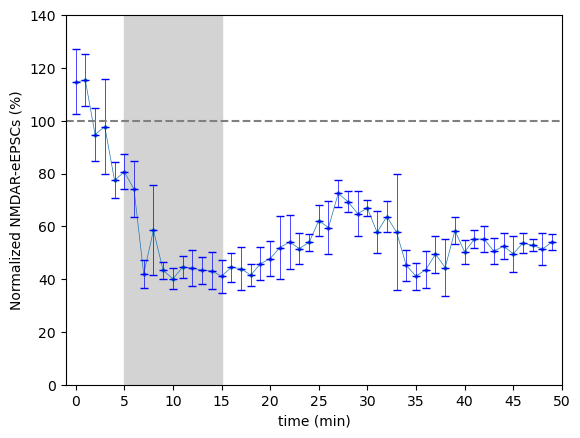

In [82]:
i = 0

for datafile in datafiles:
    try:
        #print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

        
       #info file
        recordings = get_recordings(datafile)
        diffs = get_diffs2(recordings)
        batches_m, batches_std = get_batches_rec(diffs)
        print(batches_m[0:10])
        print(batches_m[10:15])
        print(batches_m[15:50])

        # Calculate baseline mean and standard deviation
        baseline_m = np.mean(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        baseline_std = np.std(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])

        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


## + remove noise

File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.
noise :  0.05619835265105212
[0.030533017566424583, 0.03144879321289438, 0.029733574927693924, 0.027842881841135054, 0.02798489360222937, 0.027931299205948334, 0.02740272758771301, 0.027066934843295764, 0.027767473847699883, 0.029935283017992618, 0.03159304156426516, 0.03360935482737553, 0.023722696733786557, 0.022321493479897706, 0.020553235569689493, 0.019645673570163277, 0.024190551789819336, 0.019997159888026132, 0.021949052482189185, 0.022843622951617987, 0.021886206535003172, 0.02027737191540389, 0.02302507458698085, 0.021673188872294646, 0.02309402254601199, 0.022775229728359093, 0.021571064273499318, 0.021678986785812298, 0.023988485682121207, 0.026641096233443656, 0.024119331246153702, 0.024598513666520067, 0.024645218708687685, 0.030097462100826516, 0.02511901494292866, 0.024988670398124246, 0.025554444850972288, 0.025

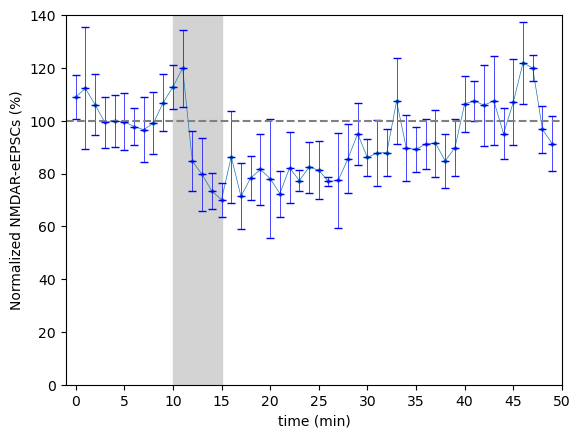

File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.
noise :  0.0834819965913902
[0.0431068218288869, 0.04332182592983821, 0.035611602485353895, 0.036735063169737854, 0.029088437110864247, 0.030290598318147257, 0.02785059386019784, 0.01577220166737701, 0.02197505307295479, 0.016287817531776678, 0.015070052166183115, 0.016737044341394235, 0.016607880913056077, 0.01627482606816494, 0.016207721211243992, 0.01544240366476801, 0.016688245701712495, 0.016536302385494046, 0.015590284861494696, 0.01720752995582263, 0.01795321708854949, 0.01952424037127433, 0.02031616725194644, 0.01937612654722044, 0.020262232827618635, 0.023348179666591612, 0.022363080293393362, 0.027222796568434713, 0.02605368670825875, 0.024361087330919174, 0.02511849544689528, 0.02167027179657673, 0.023931383573350635, 0.02170330917151655, 0.01697042605002951, 0.015451726696907498, 0.016375411822716596, 0.01857827662137

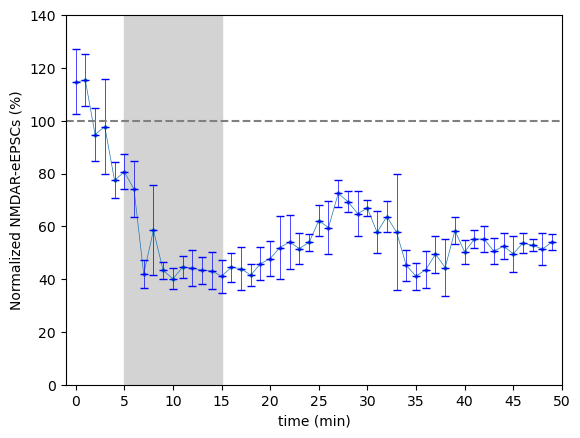

In [112]:
i = 0

for datafile in datafiles:
    try:
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

        
       #info file
        recordings = get_recordings(datafile)
        diffs = get_diffs2(recordings)
        batches_m, batches_std = get_batches_rec(diffs)
        #print(batches_m)
        '''
        #remove noise
        bsl_mins, bsl_maxs = get_mins_maxs_baselines(diffs)
        noises = []
        for k in range(len(bsl_mins)):
            noises.append(np.abs(bsl_mins[k] - bsl_maxs[k]))

        noise = 0.02
        print("NOISE ", noises )
        print(len(noises))
        
        for j in range(len(batches_m)):
                batches_m[j] -= noise

        '''

        std_baseline = get_std_baseline(info_df, diffs)
        noise = np.sqrt(std_baseline)
        #noise = 2*std_baseline
        print("noise : ", noise)
        print(batches_m)

        #for j in range(len(batches_m)):
        #        batches_m[j] = np.max(batches_m[j]-noise, 0)
        
        # Calculate baseline mean 
        baseline_m = np.mean(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        baseline_std = np.std(batches_m[(info_df["infusion start"][i]-5):info_df["infusion start"][i]])
        print(baseline_std)

        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        #print(batches_m_norm)
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????
        #print(batches_std_norm)

        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.
baseline mean 0.02950863223007546
baseline minimum 0.027842881841135054
baseline maximum 0.03144879321289438
threshold: 0.0036059113717593246
Error analysing this file: 49
Error analysing this file: 50


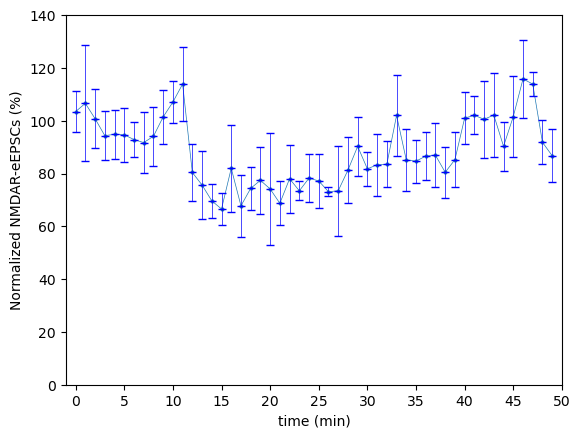

In [34]:
i = 0

for datafile in datafiles:
    try:
        
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

       #info file
        recordings = get_recordings(datafile)
        diffs = get_diffs2(recordings)
        batches_m, batches_std = get_batches_rec(diffs)

        # Calculate baseline mean and standard deviation
        baseline_m = np.mean(batches_m[0:5])
        baseline_std = np.std(batches_m[0:5])
        baseline_min = np.min(batches_m[0:5])
        baseline_max = np.max(batches_m[0:5])
        print("baseline mean", baseline_m)
        print("baseline minimum", baseline_min)
        print("baseline maximum", baseline_max)
        noise =  baseline_max - baseline_min

        
        #remove noise
        print("threshold:", noise)
        for i in range(len(batches_m)):
            if batches_m[i] <= noise: ##0.02
                print("below threshold")
                batches_m[i] = 0.00
       

        '''
        for value in batches_m:
            print(value)
            if value <= 0.02:
                print("below threshold")
                value=0.00
            print(value)
        '''
        '''
        #remove noise
        print("threshold:", 2*baseline_std)
        for value in batches_m:
            if value <= 2*baseline_std:
                print(value)
                print("below threshold")
                value=0
        '''
      
        #print(len(batches_m))   
        #print(batches_m)   
        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        #print(batches_m_norm)
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????


        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()
       

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1


## plot baseline evolution as well

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp
File : 20Jun2024c0_002
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.
Error analysing this file: 'yerr' (shape: (50, 6000)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (50,))
D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp
File : 21Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.
Error analysing this file: 'yerr' (shape: (38, 6000)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (38,))
D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp
File : 28Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentra

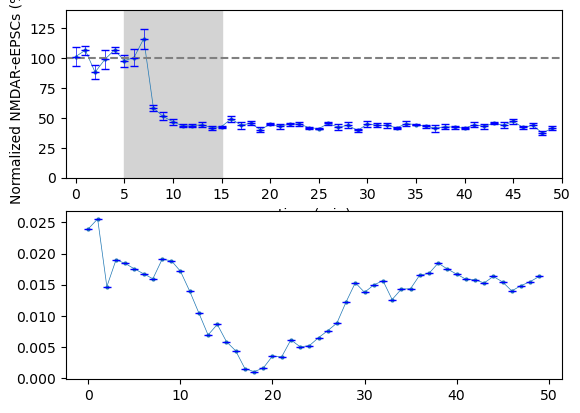

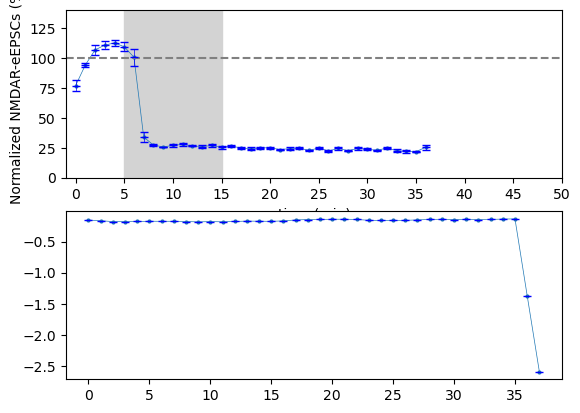

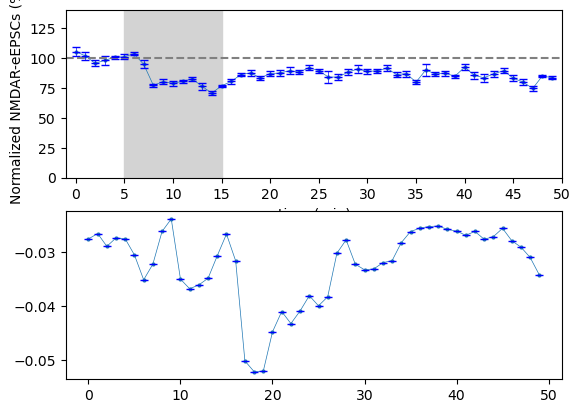

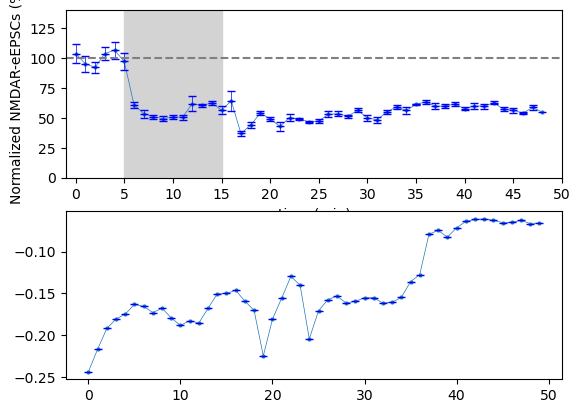

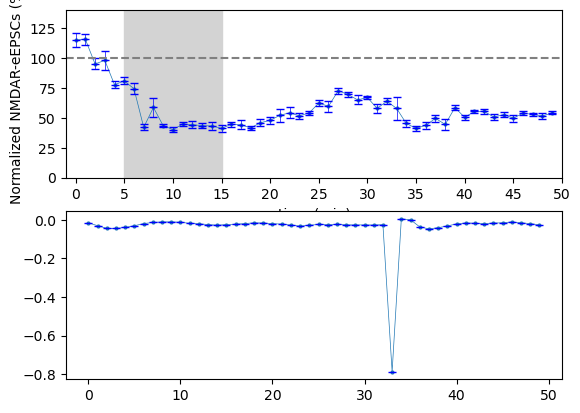

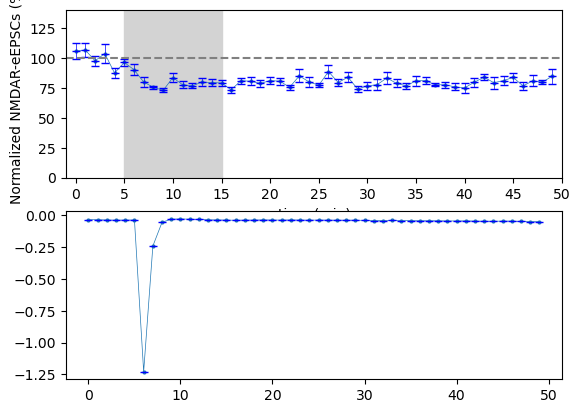

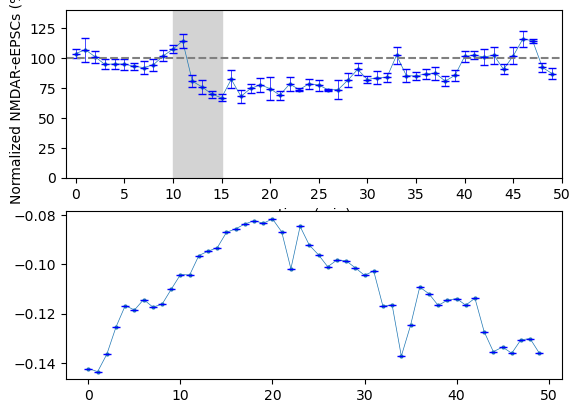

In [68]:
i = 0

for file in files:
    try:
        #notes
        print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

        #info file
        datafile = loadpxp(file)
        recordings = get_recordings(datafile)
        diffs = get_diffs2(recordings)
        batches_m, batches_std = get_batches_rec(diffs)

        baselines = get_baselines(recordings)
        baselines_m, baselines_std = get_batches_rec(baselines)

        # Calculate baseline mean and standard deviation
        baseline_m = np.mean(batches_m[0:5])
        baseline_std = np.std(batches_m[0:5])

        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

        fig, ax = plt.subplots(2)
        ax[0].plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax[0].errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax[0].set_xlim(-1, 50 )
        ax[0].set_ylim( 0, 140)
        ax[0].set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax[0].set_xlabel("time (min)")
        ax[0].set_xticks(np.arange(0, 51, 5))
        ax[0].axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax[0].axhline(100, color="grey", linestyle="--")

        ax[1].plot(baselines_m, marker="o", linewidth=0.5, markersize=2)
        ax[1].errorbar(range(len(baselines_m)), baselines_m, yerr=baselines_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax[1].set_xlim(-1, 50 )
        #ax[1].set_ylim( 0, 140)
        ax[1].set_ylabel("Baseline (=leak) (nA)")
        ax[1].set_xlabel("time (min)")
        ax[1].set_xticks(np.arange(0, 51, 5))
        ax[1].axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1
